# Workbook

In [3]:
# import necessary packages

import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from IPython import display
import tensorflow as tf
import pandas as pd
import librosa

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.listdir('/content/drive/My Drive/')

audio_path = '/content/drive/My Drive/dataset/AUDIO_NEW/'

audio_types = ['breathing', 'cough', 'speech']

Mounted at /content/drive


In [5]:
def get_directories(audio_path, audio_type):
    from pathlib import Path

    POS = os.path.join(audio_path + audio_type, 'COVID_Positive')
    NEG = os.path.join(audio_path + audio_type, 'COVID_Negative')

    # Specify the directory path
    pos_directory = Path(POS)
    neg_directory = Path(NEG)

    # List all files in the directory using iterdir()
    # pos_files = [file.name for file in pos_directory.iterdir() if file.is_file()]
    # neg_files = [file.name for file in neg_directory.iterdir() if file.is_file()]

    return pos_directory, neg_directory

### breathing mel spectrogram

In [6]:
pos_directory_breathing, neg_directory_breathing = get_directories(audio_path, audio_types[0])

# Load and process cough data
pos_directory_cough, neg_directory_cough = get_directories(audio_path, audio_types[1]) # audio_types[1] is 'cough'

# Load and process speech data
pos_directory_speech, neg_directory_speech = get_directories(audio_path, audio_types[2]) # audio_types[2] is 'speech'


In [7]:
def create_mel_spectrogram(y, sr, file_path):
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=512, hop_length=128, n_mels=128)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Normalize the spectrogram
    if np.std(log_mel_spectrogram) == 0:
        print("log_mel_spectrogram == 0: ", file_path.resolve())
    # Normalize the spectrogram
    epsilon = 1e-6  # Small value to avoid division by zero
    log_mel_spectrogram = (log_mel_spectrogram - np.mean(log_mel_spectrogram)) / (np.std(log_mel_spectrogram) + epsilon)

    # Add channel dimension
    log_mel_spectrogram = np.expand_dims(log_mel_spectrogram, axis=-1)

    return log_mel_spectrogram
def create_zero_crossing_rate(y):
    return np.mean(librosa.feature.zero_crossing_rate(y))
def create_spectral_centroid(y, sr):
    return np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))

In [8]:
def create_features(pos_directory, neg_directory, target_length):
    spectrograms = []
    other_features = []
    labels = []

    # Access files directly using iterdir()
    for file_path in pos_directory.iterdir():
        y, sr = librosa.load(file_path, sr=16000)
        y = y[:target_length]

        zero_padding = np.zeros(target_length - len(y), dtype=np.float32)
        y = np.concatenate([y, zero_padding], axis=0)

        spectrograms.append(create_mel_spectrogram(y, sr, file_path))
        other_features.append([create_zero_crossing_rate(y), create_spectral_centroid(y, sr)])
        labels.append(1)

    for file_path in neg_directory.iterdir():
        y, sr = librosa.load(file_path, sr=16000)
        y = y[:target_length]

        zero_padding = np.zeros(target_length - len(y), dtype=np.float32)
        y = np.concatenate([y, zero_padding], axis=0)

        spectrograms.append(create_mel_spectrogram(y, sr, file_path))
        other_features.append([create_zero_crossing_rate(y), create_spectral_centroid(y, sr)])
        labels.append(0)

    print("Completed creating features for {0} and {1}! ".format(pos_directory, neg_directory))

    return spectrograms, other_features, labels

In [9]:

 spectrograms, other_features, labels = create_features(pos_directory_breathing, neg_directory_breathing, 80000)
 spectrograms_cough, other_features_cough, labels_cough = create_features(pos_directory_cough, neg_directory_cough, 80000)
 spectrograms_speech, other_features_speech, labels_speech = create_features(pos_directory_speech, neg_directory_speech, 80000)


log_mel_spectrogram == 0:  /content/drive/My Drive/dataset/AUDIO_NEW/breathing/COVID_Negative/TMWZXJNT.flac
log_mel_spectrogram == 0:  /content/drive/My Drive/dataset/AUDIO_NEW/breathing/COVID_Negative/HTUZHMVC.flac
log_mel_spectrogram == 0:  /content/drive/My Drive/dataset/AUDIO_NEW/breathing/COVID_Negative/GDOLSUHV.flac
Completed creating features for /content/drive/My Drive/dataset/AUDIO_NEW/breathing/COVID_Positive and /content/drive/My Drive/dataset/AUDIO_NEW/breathing/COVID_Negative! 
log_mel_spectrogram == 0:  /content/drive/My Drive/dataset/AUDIO_NEW/cough/COVID_Negative/TMWZXJNT.flac
Completed creating features for /content/drive/My Drive/dataset/AUDIO_NEW/cough/COVID_Positive and /content/drive/My Drive/dataset/AUDIO_NEW/cough/COVID_Negative! 
Completed creating features for /content/drive/My Drive/dataset/AUDIO_NEW/speech/COVID_Positive and /content/drive/My Drive/dataset/AUDIO_NEW/speech/COVID_Negative! 


In [8]:
# # List to store spectrograms and labels
# spectrograms = []
# zero_crossing_rates = []
# spectral_centroids = []
# labels = []

# for file_path in pos_directory.iterdir():
#     y, sr = librosa.load(file_path.resolve(), sr=16000)
#     y = y[:80000]

#     zero_padding = np.zeros(80000 - len(y), dtype=np.float32)
#     y = np.concatenate([y, zero_padding],axis=0)

#     mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=512, hop_length=128, n_mels=128)
#     log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

#     # Normalize the spectrogram
#     log_mel_spectrogram = (log_mel_spectrogram - np.mean(log_mel_spectrogram)) / np.std(log_mel_spectrogram)

#     log_mel_spectrogram = np.expand_dims(log_mel_spectrogram, axis=-1)  # Add channel dimension

#     # Append to list
#     spectrograms.append(log_mel_spectrogram)

#     zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y))
#     spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))

#     zero_crossing_rates.append(zero_crossing_rate)
#     spectral_centroids.append(spectral_centroid)

#     labels.append(1)  # Assuming binary classification

# for file_path in neg_directory.iterdir():
#     y, sr = librosa.load(file_path.resolve(), sr=16000)
#     y = y[:80000]

#     zero_padding = np.zeros(80000 - len(y), dtype=np.float32)
#     y = np.concatenate([y, zero_padding],axis=0)

#     mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=512, hop_length=128, n_mels=128)
#     log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

#     if np.std(log_mel_spectrogram) == 0:
#         print(file_path.resolve())
#     # Normalize the spectrogram
#     epsilon = 1e-6  # Small value to avoid division by zero
#     log_mel_spectrogram = (log_mel_spectrogram - np.mean(log_mel_spectrogram)) / (np.std(log_mel_spectrogram) + epsilon)

#     log_mel_spectrogram = np.expand_dims(log_mel_spectrogram, axis=-1)  # Add channel dimension
#     #print(log_mel_spectrogram.shape)
#     # Append to list
#     spectrograms.append(log_mel_spectrogram)

#     zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y))
#     spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))

#     zero_crossing_rates.append(zero_crossing_rate)
#     spectral_centroids.append(spectral_centroid)

#     labels.append(0)

In [10]:
all_spectrograms = spectrograms_cough + spectrograms_speech + spectrograms
all_other_features = other_features_cough + other_features_speech + other_features
all_labels = labels_cough + labels_speech + labels

# Convert to NumPy arrays
all_spectrograms = np.array(all_spectrograms)
all_other_features = np.array(all_other_features)
all_labels = np.array(all_labels)
all_spectrograms_flattened = all_spectrograms.reshape(all_spectrograms.shape[0], -1)

In [11]:
all_spectrograms.shape

(2895, 128, 626, 1)

In [12]:
all_spectrograms

array([[[[-0.6158209 ],
         [-0.6158209 ],
         [-0.6158209 ],
         ...,
         [-0.6158209 ],
         [-0.6158209 ],
         [-0.6158209 ]],

        [[-0.6158209 ],
         [-0.6158209 ],
         [-0.6158209 ],
         ...,
         [-0.6158209 ],
         [-0.6158209 ],
         [-0.6158209 ]],

        [[-0.6158209 ],
         [-0.6158209 ],
         [-0.6158209 ],
         ...,
         [-0.6158209 ],
         [-0.6158209 ],
         [-0.6158209 ]],

        ...,

        [[-0.6158209 ],
         [-0.6158209 ],
         [-0.6158209 ],
         ...,
         [-0.6158209 ],
         [-0.6158209 ],
         [-0.6158209 ]],

        [[-0.6158209 ],
         [-0.6158209 ],
         [-0.6158209 ],
         ...,
         [-0.6158209 ],
         [-0.6158209 ],
         [-0.6158209 ]],

        [[-0.6158209 ],
         [-0.6158209 ],
         [-0.6158209 ],
         ...,
         [-0.6158209 ],
         [-0.6158209 ],
         [-0.6158209 ]]],


       [[[-0.43409294],


In [13]:
all_spectrograms_flattened

array([[-0.6158209 , -0.6158209 , -0.6158209 , ..., -0.6158209 ,
        -0.6158209 , -0.6158209 ],
       [-0.43409294, -0.43409294,  0.7811032 , ..., -0.43409294,
        -0.43409294, -0.43409294],
       [-0.55367666, -0.55367666, -0.55367666, ..., -0.55367666,
        -0.55367666, -0.55367666],
       ...,
       [-1.338198  , -1.338198  , -1.338198  , ..., -1.338198  ,
        -1.338198  , -1.338198  ],
       [-1.0112269 , -1.0112269 , -1.0112269 , ..., -1.0112269 ,
        -1.0082093 , -0.6970864 ],
       [-0.97825336, -0.97825336, -0.97825336, ..., -0.97825336,
        -0.97825336, -0.97825336]], dtype=float32)

In [14]:
X_combined = np.hstack([all_spectrograms_flattened, all_other_features])

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_combined, all_labels, test_size=0.2, stratify=all_labels)

In [16]:
X_combined[0]

array([-6.15820885e-01, -6.15820885e-01, -6.15820885e-01, ...,
       -6.15820885e-01,  1.81811679e-01,  1.75672199e+03])

In [16]:
# Flatten each spectrogram into a single vector
# Resulting shape will be (num_samples, height * width * channels)
# X_train_numpy = np.array(X_train)
# X_train_flattened = X_train_numpy.reshape(X_train_numpy.shape[0], -1)

# print(f"Original shape: {X_train_numpy.shape}")
# print(f"Flattened shape: {X_train_flattened.shape}")

In [17]:
!pip install imbalanced-learn
from imblearn.combine import SMOTEENN
from collections import Counter

smote_enn = SMOTEENN(random_state=seed)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# Print resampled class distribution
print(f"Resampled class distribution: {Counter(y_train_resampled)}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 4.4 MB/s eta 0:00:00
Resampled class distribution: Counter({1: 1863, 0: 358})


In [ ]:
# from imblearn.combine import SMOTEENN
# from collections import Counter

# smote_enn = SMOTEENN(random_state=seed)
# X_resampled, y_resampled = smote_enn.fit_resample(X_train_flattened, y_train)

# # Print resampled class distribution
# print(f"Resampled class distribution: {Counter(y_resampled)}")

In [ ]:
# # Reshape back to original format after resampling
# X_resampled = X_resampled.reshape(X_resampled.shape[0], 128, 626, 1)

# print(f"Reshaped back to original format: {X_resampled.shape}")

In [18]:
num_spectrogram_features = 128 * 626  # Flattened size

In [19]:
# Separate resampled spectrograms and other features for X_train_resampled
spectrograms_resampled = X_train_resampled[:, :num_spectrogram_features]
other_features_resampled = X_train_resampled[:, num_spectrogram_features:]

In [ ]:
# spectrograms_resampled

In [20]:
# Reshape the flattened spectrograms back to their original shape (128x626)
spectrograms_resampled_reshaped = spectrograms_resampled.reshape(spectrograms_resampled.shape[0], 128, 626, 1)

In [24]:
# Optionally add a channel dimension for CNN input (e.g., shape: [samples, 128, 626, 1])
#spectrograms_resampled_reshaped = np.expand_dims(spectrograms_resampled_reshaped, axis=-1)

In [21]:
spectrograms_resampled_reshaped.shape

(2221, 128, 626, 1)

In [22]:
other_features_resampled.shape

(2221, 2)

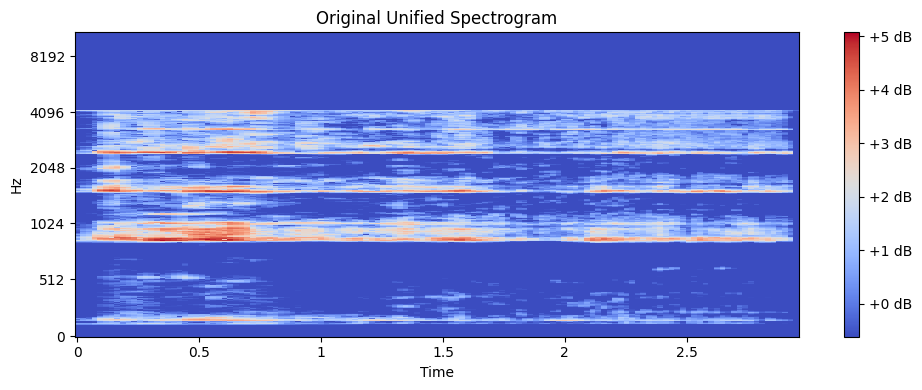

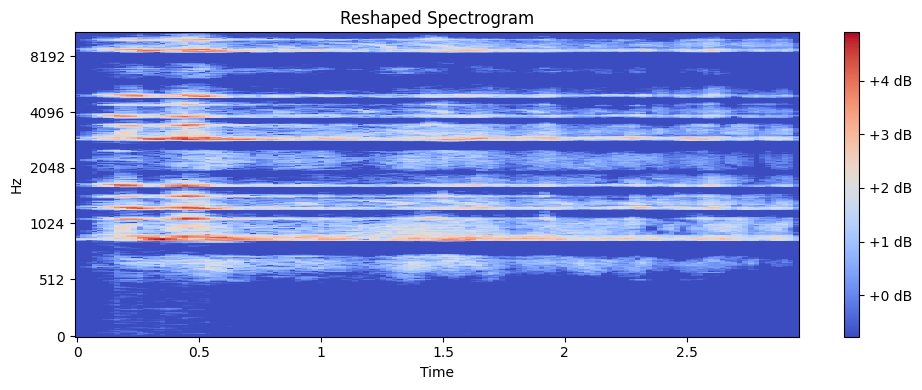

In [23]:
import random
import matplotlib.pyplot as plt
import librosa.display

# Function to plot spectrogram
def plot_spectrogram(spectrogram, title):
    plt.figure(figsize=(10, 4))
    # Remove channel dimension if present for visualization
    if spectrogram.shape[-1] == 1:
        spectrogram = spectrogram.squeeze(-1)
    librosa.display.specshow(spectrogram.T, sr=22050, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Assuming 'original_spectrogram' is your original unflattened spectrogram
# and 'reshaped_spectrogram' is your reshaped version after processing

# Plot original spectrogram (before flattening)
plot_spectrogram(all_spectrograms[0], "Original Unified Spectrogram")

plot_spectrogram(spectrograms_resampled_reshaped[100], "Reshaped Spectrogram")



In [24]:
# For X_test (no resampling needed), separate and reshape the spectrograms
spectrograms_test = X_test[:, :num_spectrogram_features]
other_features_test = X_test[:, num_spectrogram_features:]
spectrograms_test_reshaped = spectrograms_test.reshape(spectrograms_test.shape[0], 128, 626, 1)

In [25]:
y_train_resampled = np.array(y_train_resampled)
y_test = np.array(y_test)

In [ ]:
# y_resampled = np.array(y_resampled)

### Single input model

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, GlobalAveragePooling2D

In [27]:
model = Sequential()
model.add(Input(shape=(128,626,1)))

# First Conv2D layer followed by MaxPooling
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # Reduces spatial dimensions by half

# Second Conv2D layer followed by MaxPooling
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # Further reduces spatial dimensions

# Third Conv2D layer followed by MaxPooling
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # Further reduces spatial dimensions

# Fourth Conv2D layer followed by MaxPooling (new)
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # Further reduces spatial dimensions

# Flatten and Dense layers
#model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [28]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 624, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 312, 16)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 310, 16)       2320      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 155, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 153, 32)       4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 76, 32)        0

In [32]:
# Reshape X_train_spectrograms to have the same shape as the spectrograms_resampled_reshaped
# using num_spectrogram_features, which is 128 * 626 in this case.
# X_train_spectrograms = X_train[:, :num_spectrogram_features]  # Extract spectrogram features from training data
# X_train_spectrograms_reshaped = X_train_spectrograms.reshape(X_train_spectrograms.shape[0], 128, 626, 1)  # Reshape to (samples, 128, 626, 1)


# hist = model.fit(
#     X_train_spectrograms_reshaped,  # Pass the reshaped TRAINING spectrograms as input
#     y_train,  # Labels
#     batch_size=16,
#     verbose=2,
#     epochs=20,
#     validation_split=0.1
# )
hist = model.fit(
    X_train_resampled[:, :num_spectrogram_features].reshape(-1, 128, 626, 1),  # Mel spectrograms
    y_train_resampled,
    batch_size=8,
    verbose=2,
    epochs=10,
    validation_split=0.1
)

Epoch 1/10
250/250 - 71s - loss: 0.5099 - recall: 0.9439 - precision: 0.8203 - val_loss: 1.4409 - val_recall: 1.0000 - val_precision: 0.1767 - 71s/epoch - 286ms/step
Epoch 2/10
250/250 - 71s - loss: 0.4524 - recall: 0.9994 - precision: 0.8211 - val_loss: 1.2423 - val_recall: 1.0000 - val_precision: 0.1798 - 71s/epoch - 284ms/step
Epoch 3/10
250/250 - 71s - loss: 0.4111 - recall: 0.9774 - precision: 0.8323 - val_loss: 0.8216 - val_recall: 0.7317 - val_precision: 0.2113 - 71s/epoch - 285ms/step
Epoch 4/10
250/250 - 71s - loss: 0.3823 - recall: 0.9744 - precision: 0.8428 - val_loss: 1.3766 - val_recall: 1.0000 - val_precision: 0.1830 - 71s/epoch - 286ms/step
Epoch 5/10
250/250 - 71s - loss: 0.3642 - recall: 0.9579 - precision: 0.8557 - val_loss: 1.4746 - val_recall: 0.9268 - val_precision: 0.1836 - 71s/epoch - 283ms/step
Epoch 6/10
250/250 - 69s - loss: 0.3397 - recall: 0.9500 - precision: 0.8743 - val_loss: 1.6321 - val_recall: 0.9512 - val_precision: 0.1940 - 69s/epoch - 277ms/step
Epoc

### Fit Model, View Loss and KPI Plots

In [34]:
# Assuming 'num_spectrogram_features' is defined earlier

# Extract and reshape spectrograms
X_test_spectrograms = X_test[:, :num_spectrogram_features]
X_test_spectrograms_reshaped = X_test_spectrograms.reshape(X_test_spectrograms.shape[0], 128, 626, 1)

# Extract other features
X_test_other_features = X_test[:, num_spectrogram_features:]

# Make predictions
y_pred = model.predict(X_test_spectrograms_reshaped)


19/19 [==============================] - 7s 339ms/step


In [35]:
y_pred_binary = (y_pred > 0.99).astype(int)

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_binary)

In [37]:
len(y_test)

579

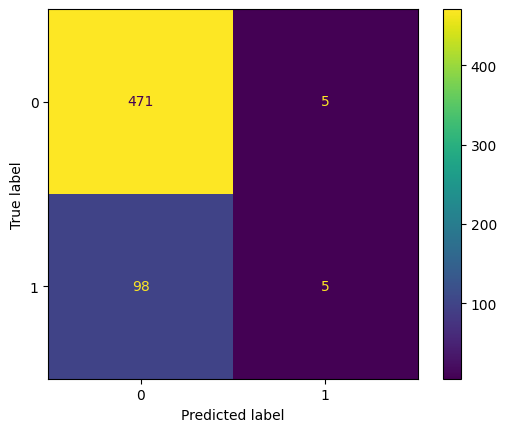

In [38]:
disp = ConfusionMatrixDisplay(cm)

disp.plot()
plt.show()

### Multi-input model

In [40]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Concatenate, Dropout

# Define input for Mel spectrogram (shape: 625 time frames x 128 frequency bins x 1 channel)
mel_input = Input(shape=(128, 626, 1), name='mel_spectrogram')

# Define CNN sub-network for Mel spectrogram
x = Conv2D(16, (3,3), activation='relu')(mel_input)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(16, (3,3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = GlobalAveragePooling2D()(x)

# Define input for other features (e.g., zero-crossing rate and spectral centroid)
other_input = Input(shape=(2,), name='other_features')

# Define a simple dense sub-network for other features
y = Dense(64, activation='relu')(other_input)
y = Dense(128, activation='relu')(y)  # Add more dense layers
y = Dropout(0.3)(y)                   # Add dropout to prevent overfitting
y = Dense(128, activation='relu')(y)   # Another dense layer
y = Dense(64, activation='relu')(y)    # Another dense layer

# Concatenate both sub-networks
combined = Concatenate()([x, y])

# Add final classification layers
z = Dense(128, activation='relu')(combined)
z = Dense(1, activation='sigmoid')(z)  # Binary classification

In [41]:
X_train_spectrograms = spectrograms_resampled_reshaped
X_train_others = other_features_resampled
y_train = y_train_resampled

In [42]:
# Define the model with two inputs
model = tf.keras.Model(inputs=[mel_input, other_input], outputs=z)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','recall','precision'])

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 mel_spectrogram (InputLaye  [(None, 128, 626, 1)]        0         []                            
 r)                                                                                               
                                                                                                  
 conv2d_4 (Conv2D)           (None, 126, 624, 16)         160       ['mel_spectrogram[0][0]']     
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 63, 312, 16)          0         ['conv2d_4[0][0]']            
 g2D)                                                                                             
                                                                                              

In [73]:
history = model.fit(
    [X_train_spectrograms,
     X_train_others],
    y_train,
    validation_split = 0.1,
    verbose = 2,
    epochs=20,
    batch_size=16
)

In [59]:
X_train_spectrograms.shape

(2221, 128, 626, 1)

In [60]:
X_train_others

array([[2.79620322e-01, 2.56025351e+03],
       [1.92214869e-01, 2.31064554e+03],
       [1.45818820e-01, 1.53143230e+03],
       ...,
       [2.11909781e-01, 1.36734499e+03],
       [1.33090055e-01, 1.19301854e+03],
       [1.59332569e-01, 1.57826325e+03]])

In [61]:
y_pred_train = model.predict([X_train_spectrograms, X_train_others])

70/70 [==============================] - 25s 355ms/step


In [62]:
y_pred_train_binary = (y_pred_train > 0.99).astype(int)

In [63]:
from sklearn.metrics import accuracy_score

accuracy_train = accuracy_score(y_train, y_pred_train_binary)

In [64]:
accuracy_train

0.8284556506078343

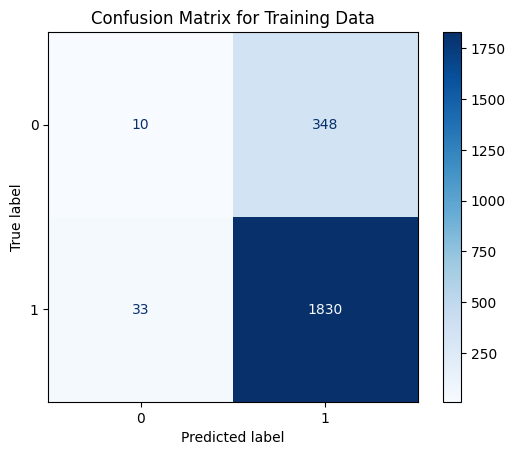

In [65]:
cm = confusion_matrix(y_train, y_pred_train_binary)

# Step 4: Visualize or print the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Training Data")
plt.show()

In [66]:
y_pred_test = model.predict([spectrograms_test_reshaped, other_features_test])

19/19 [==============================] - 6s 334ms/step


In [67]:
y_pred_test_binary = (y_pred > 0.99).astype(int)

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_test_binary)

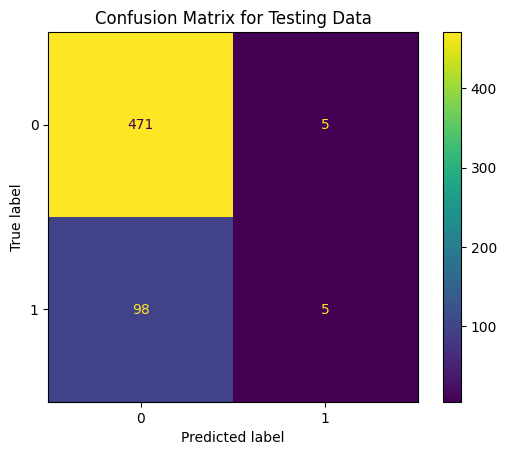

In [69]:
disp = ConfusionMatrixDisplay(cm)

disp.plot()
plt.title("Confusion Matrix for Testing Data")
plt.show()

In [70]:
from sklearn.metrics import accuracy_score

accuracy_test = accuracy_score(y_test, y_pred_test_binary)

In [71]:
accuracy_test

0.8221070811744386